In [2]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

In [3]:
def calc_acc(outputs,
             labels):  # loss or acc
    return F.mse_loss(outputs, labels.reshape(-1, 1))


def train(model: nn.Module,
          optimizer,
          num_epochs,
          device,
          train_loader,
          val_loader=None):
    # model setting
    model.train()
    model.to(device=device)

    loss_list = []

    test_acc = []
    running_loss_list = []

    best_acc = 0.
    # train loop
    for epoch_idx in range(num_epochs):
        model.train()
        running_acc = running_loss = total = 0
        tqdm_train_loader = tqdm(train_loader)
        for inputs, labels in tqdm_train_loader:
            # prepare mini-batch data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward path
            outputs = model(inputs)
            loss = F.mse_loss(outputs, labels.reshape(-1, 1))
            # print(outputs)
            # print(labels)

            # backward path
            optimizer.zero_grad()  # clear old gradients
            loss.backward()  # calculate new gradients
            optimizer.step()  # update weights

            running_loss += loss.item()
            running_acc += calc_acc(outputs, labels).item()
            total += 1

            loss_list.append(loss.item())
            ###

            tqdm_train_loader.set_postfix_str("Epoch: {e:d}, loss: {l:.4f}".format(e=epoch_idx, l=loss.item()))

            # exit()

        running_loss /= total
        running_acc /= total

        testing_acc = test(model, device, val_loader).item() # main calls test function!

        test_acc.append(testing_acc)
        running_loss_list.append(running_loss)

        # if testing_acc > best_acc:
        #     torch.save(net.state_dict(), "best.pth")
        print("Epoch {0:d}: TrainLoss {1:.6f}, "
              "TrainAcc(if reg, then TrainLoss) {2:.4f}, "
              "TestAcc(if reg, then TestLoss) {3:.4f}".format(
            epoch_idx + 1, running_loss, running_acc, testing_acc))

    # draw a picture
    # fig = plt.figure()
    # plt.clf()
    # plt.plot(range(1, epochs + 1), running_loss_list)
    # plt.plot(range(1, epochs + 1), test_acc)
    # plt.xlabel("Epochs")
    # plt.ylabel("MSE")
    # plt.legend(["Train", "Valid"])
    # plt.pause(10)
    # plt.show()

    return loss_list, test_acc


def test(model: nn.Module,
         device,
         test_loader):
    model.eval()
    model.to(device=device)
    testing_acc = total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):  # 创建进度条实例，保留dataloader的全部属性和方法！
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            testing_acc += calc_acc(outputs, labels)
            total += 1
    return testing_acc / total


class FCNN(nn.Module):  # inherit father torch.nn.Module
    def __init__(self):
        super(FCNN, self).__init__()
        self.fcnn_layer = nn.Sequential(
            nn.Linear(13, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        x = self.fcnn_layer(x)
        return x


class MyDataset(Dataset):

    def __init__(self):
        data = pd.read_csv('./data/data.csv')
        data_filled = data.fillna(0)
        # data_filled = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        csv_tensor = torch.tensor(data_filled.values, dtype=torch.float32)
        inputs, outputs = data_filled.iloc[:, 0:13], data_filled.iloc[:, 13]
        X, y = torch.tensor(inputs.values, dtype=torch.float32), torch.tensor(outputs.values, dtype=torch.float32)

        y = F.normalize(y, dim=0)
        csv_tensor = F.normalize(csv_tensor, dim=0)
        X = F.normalize(X, dim=0)

        self._x = X
        self._y = y
        self._len = len(csv_tensor)

    def __getitem__(self, index):
        return self._x[index], self._y[index]

    def __len__(self):
        return self._len

In [4]:
batch_size = 10
epochs = 5
learning_rate = 1e-4
weight_decay = 1e-5
device = torch.device("cpu")

In [5]:
dataset = MyDataset()
train_set, val_set = torch.utils.data.dataset.random_split(dataset, [340, 25])  # 340 + 25 = 365
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size)

model = FCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train(model,
      optimizer,
      epochs,
      device,
      train_loader,
      val_loader)

100%|██████████| 3/3 [00:00<?, ?it/s]


Epoch 1: TrainLoss 0.022575, TrainAcc(if reg, then TrainLoss) 0.0226, TestAcc(if reg, then TestLoss) 0.0180


100%|██████████| 3/3 [00:00<00:00, 749.12it/s]


Epoch 2: TrainLoss 0.014886, TrainAcc(if reg, then TrainLoss) 0.0149, TestAcc(if reg, then TestLoss) 0.0114


100%|██████████| 3/3 [00:00<00:00, 1497.43it/s]


Epoch 3: TrainLoss 0.009192, TrainAcc(if reg, then TrainLoss) 0.0092, TestAcc(if reg, then TestLoss) 0.0067


100%|██████████| 3/3 [00:00<00:00, 750.55it/s]


Epoch 4: TrainLoss 0.005291, TrainAcc(if reg, then TrainLoss) 0.0053, TestAcc(if reg, then TestLoss) 0.0037


100%|██████████| 3/3 [00:00<?, ?it/s]

Epoch 5: TrainLoss 0.002864, TrainAcc(if reg, then TrainLoss) 0.0029, TestAcc(if reg, then TestLoss) 0.0019


([0.028045877814292908,
  0.02522340789437294,
  0.02533264085650444,
  0.023895565420389175,
  0.026486575603485107,
  0.025227323174476624,
  0.02484198659658432,
  0.026327157393097878,
  0.025063257664442062,
  0.02148304134607315,
  0.02465413324534893,
  0.025397807359695435,
  0.023339081555604935,
  0.023171856999397278,
  0.025197207927703857,
  0.023158088326454163,
  0.025946130976080894,
  0.020652953535318375,
  0.023187078535556793,
  0.022375067695975304,
  0.021270863711833954,
  0.021472981199622154,
  0.021909838542342186,
  0.02141544595360756,
  0.02092750370502472,
  0.01838972419500351,
  0.01954236999154091,
  0.018620729446411133,
  0.02089618518948555,
  0.019777877256274223,
  0.018727922812104225,
  0.018749769777059555,
  0.018836630508303642,
  0.018003996461629868,
  0.01427591871470213,
  0.017128420993685722,
  0.01714881882071495,
  0.016152273863554,
  0.018304739147424698,
  0.016822664067149162,
  0.01663549244403839,
  0.017080461606383324,
  0.0161

In [6]:
X = dataset._x
y = dataset._y
# X.shape[0]
val = model(X[90])
val

tensor([0.0071], grad_fn=<ViewBackward0>)

In [7]:
background = shap.utils.sample(X, 100)
e0 = shap.DeepExplainer(model.eval(), background)
shap_values0 = e0.shap_values(X)

In [8]:
type(shap_values0)

numpy.ndarray

In [9]:
shap_values0[0].shape

(13, 1)

In [10]:
print(shap_values0[0][0])

[-0.00032768]


In [11]:
print(shap_values0[1][0])

[-0.00032768]


In [12]:
print(shap_values0[90])

[[ 2.77648487e-05]
 [ 4.26489045e-04]
 [ 9.02584361e-06]
 [-1.18328353e-04]
 [ 0.00000000e+00]
 [ 4.07152373e-04]
 [-1.51462431e-04]
 [-1.87865699e-05]
 [-9.24287888e-04]
 [-1.17700803e-03]
 [ 1.03352853e-04]
 [ 4.77190886e-04]
 [ 1.31318637e-04]]


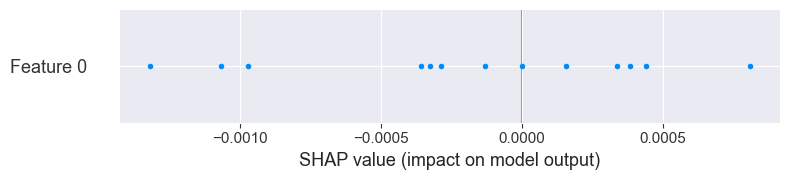

In [15]:
shap.summary_plot(shap_values0[0])
